In [1]:
import opendatasets as od

In [2]:
od.download('https://www.kaggle.com/datasets/ejlok1/cremad')


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading cremad.zip to .\cremad


100%|██████████| 451M/451M [06:19<00:00, 1.25MB/s] 


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt    
%matplotlib inline

In [4]:
folder_path="D:/speech_recognition/cremad/cremad/AudioWAV/"
x= os.listdir(folder_path)
emotion=[]
file_path=[]

for file in x:
    file_path.append(folder_path + file)
    filename_identifiers=file.split('_')
    if filename_identifiers[2] == 'SAD':
        emotion.append('sad')
    elif filename_identifiers[2] == 'ANG':
        emotion.append('angry')
    elif filename_identifiers[2] == 'DIS':
        emotion.append('disgust')
    elif filename_identifiers[2] == 'FEA':
        emotion.append('fear')
    elif filename_identifiers[2] == 'HAP':
        emotion.append('happy')
    elif filename_identifiers[2] == 'NEU':
        emotion.append('neutral')
    else:
        emotion.append('Unknown')
        

CREMA_df = pd.DataFrame(emotion, columns=['emotion'])
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)

In [5]:
CREMA_df

,emotion,path
0,angry,D:/speech_recognition/cremad/cremad/AudioWAV/1...
1,disgust,D:/speech_recognition/cremad/cremad/AudioWAV/1...
2,fear,D:/speech_recognition/cremad/cremad/AudioWAV/1...
3,happy,D:/speech_recognition/cremad/cremad/AudioWAV/1...
4,neutral,D:/speech_recognition/cremad/cremad/AudioWAV/1...
...,...,...
7437,disgust,D:/speech_recognition/cremad/cremad/AudioWAV/1...
7438,fear,D:/speech_recognition/cremad/cremad/AudioWAV/1...
7439,happy,D:/speech_recognition/cremad/cremad/AudioWAV/1...
7440,neutral,D:/speech_recognition/cremad/cremad/AudioWAV/1...


<AxesSubplot: >

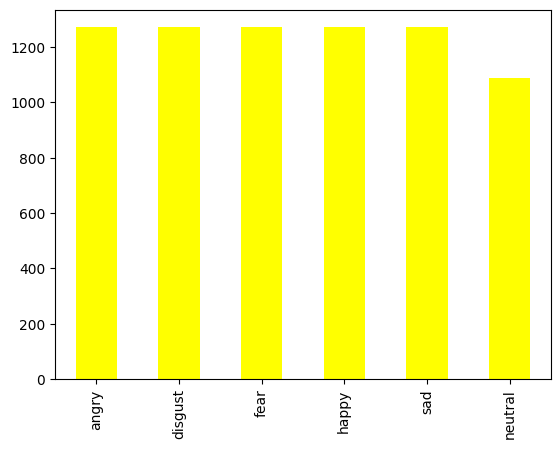

In [6]:
CREMA_df.emotion.value_counts().plot(kind='bar', color='yellow')

In [7]:
import librosa

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [8]:
def extract_features(data,sample_rate):
    
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) 

    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) 

    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) 

    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) 

    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    
    return result

def get_features(path):
    
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    res1 = extract_features(data,sample_rate)
    result = np.array(res1)
    
    noise_data = noise(data)
    res2 = extract_features(noise_data,sample_rate )
    result = np.vstack((result, res2)) 
    
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3))
    
    return result

In [9]:
X, Y = [], []
for path, emotion in zip(CREMA_df.path, CREMA_df.emotion):
    features = get_features(path)
    for i in features:
        X.append(i)
        Y.append(emotion)

C:\Users\Manav\AppData\Local\Temp\ipykernel_2892\1313063952.py:9: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.time_stretch(data, rate)
C:\Users\Manav\AppData\Local\Temp\ipykernel_2892\1313063952.py:16: FutureWarning: Pass sr=22050, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
c:\Users\Manav\anaconda3\envs\tf2.11\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


In [10]:
import librosa.display
from IPython.display import Audio
def create_waveplot(data, sr, e):
    
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

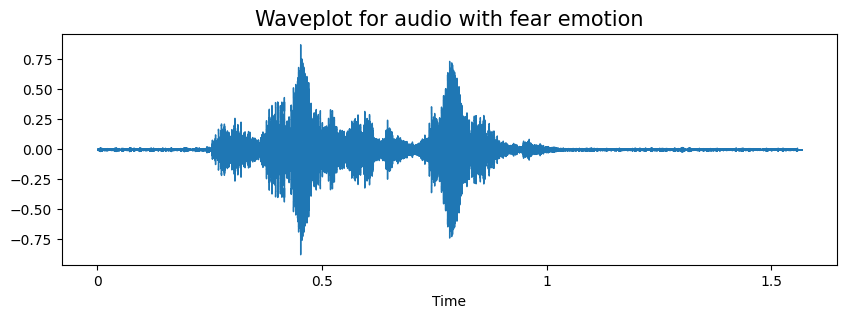

In [11]:
emotion='fear'
path = 'D:/speech_recognition/cremad/cremad/AudioWAV/1001_IEO_FEA_HI.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
Audio(path)

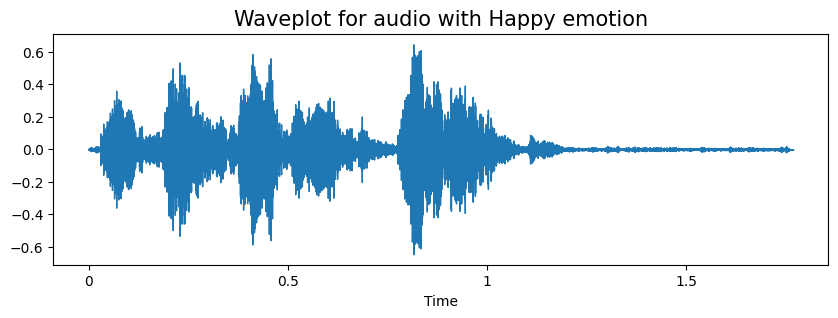

In [12]:
emotion='Happy'
path = 'D:/speech_recognition/cremad/cremad/AudioWAV/1001_IEO_HAP_HI.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
Audio(path)

In [13]:
CREMA_df = pd.DataFrame(X)
CREMA_df['emotion'] = Y
CREMA_df.to_csv('features.csv', index=False)
CREMA_df

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,emotion
0,0.083837,0.677546,0.700793,0.678332,0.680873,0.679725,0.584707,0.583747,0.652854,0.656525,...,6.626328e-08,6.204718e-08,5.876392e-08,5.609468e-08,5.394531e-08,5.227853e-08,5.099204e-08,5.010444e-08,4.954257e-08,angry
1,0.084172,0.679089,0.702239,0.679735,0.682350,0.681320,0.584988,0.583093,0.652425,0.656104,...,1.488362e-07,1.471931e-07,1.383146e-07,1.396011e-07,1.355517e-07,1.349207e-07,1.251890e-07,1.334787e-07,1.343373e-07,angry
2,0.091711,0.659439,0.620962,0.630467,0.676151,0.724627,0.611476,0.552105,0.626552,0.630631,...,6.375256e-08,5.868657e-08,5.494053e-08,5.213360e-08,4.897915e-08,4.116958e-08,2.717842e-08,1.526914e-08,1.062208e-08,angry
3,0.077155,0.723378,0.734000,0.657600,0.669668,0.691899,0.606737,0.581587,0.622560,0.685837,...,4.660350e-07,4.323460e-07,4.062581e-07,3.852635e-07,3.684870e-07,3.555282e-07,3.455847e-07,3.387376e-07,3.344437e-07,disgust
4,0.257038,0.823089,0.809249,0.798704,0.832377,0.771152,0.673472,0.666534,0.727944,0.755665,...,2.390131e-03,2.263478e-03,2.450648e-03,2.338404e-03,2.169870e-03,2.222930e-03,2.233124e-03,2.282110e-03,2.307430e-03,disgust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22321,0.101784,0.468680,0.583917,0.538757,0.508096,0.596213,0.624678,0.670717,0.696466,0.677656,...,1.864013e-06,1.914233e-06,1.889159e-06,1.861876e-06,1.854771e-06,1.815760e-06,1.783612e-06,1.814524e-06,1.740475e-06,neutral
22322,0.106684,0.532952,0.488084,0.648924,0.561141,0.521932,0.573979,0.578779,0.644596,0.692738,...,3.520682e-07,3.233681e-07,3.027550e-07,2.868969e-07,2.692790e-07,2.260457e-07,1.491431e-07,8.372803e-08,5.823781e-08,neutral
22323,0.065388,0.495402,0.498732,0.489753,0.596014,0.707405,0.644182,0.604431,0.609171,0.740128,...,2.681083e-09,2.245909e-09,1.963724e-09,1.770401e-09,1.634740e-09,1.539556e-09,1.472273e-09,1.428032e-09,1.401615e-09,sad
22324,0.147604,0.634286,0.634375,0.635178,0.733374,0.822794,0.714428,0.650412,0.666586,0.760637,...,1.740613e-04,1.753489e-04,1.840626e-04,1.828491e-04,1.802107e-04,1.686556e-04,1.751877e-04,1.762788e-04,1.652803e-04,sad


In [14]:
from sklearn.model_selection import train_test_split
X = CREMA_df.drop(['emotion'], axis=1)
feature_names = list(X.columns)
X = X.values
labels = np.sort(np.unique(CREMA_df.emotion.values))
index = {}
val = {}
for i, j in enumerate(labels):
    index[j] = i
    val[i] = j
y = np.array([index[x] for x in CREMA_df.emotion.values])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svclassifier = SVC()
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
acc = float(accuracy_score(y_test,y_pred))*100
print("Accuracy Score is:", acc)

Accuracy Score is: 38.96452884270871


c:\Users\Manav\anaconda3\envs\tf2.11\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


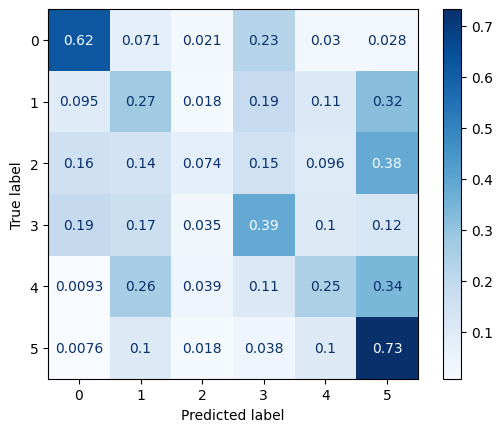

In [16]:
from sklearn.metrics import plot_confusion_matrix
matrix = plot_confusion_matrix(svclassifier,X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.show(matrix)
plt.show()

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
acc = float(accuracy_score(y_test,y_pred))*100
print("Accuracy Score is:", acc)

Accuracy Score is: 44.94804729487639


c:\Users\Manav\anaconda3\envs\tf2.11\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


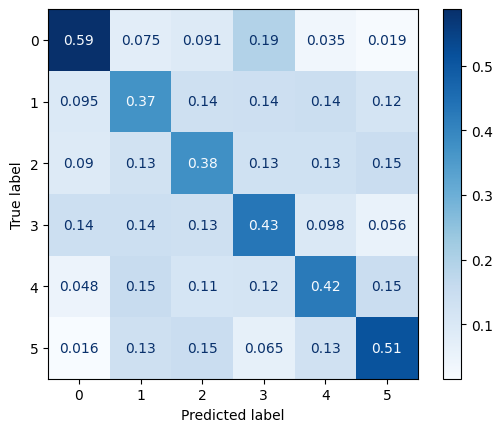

In [18]:
from sklearn.metrics import plot_confusion_matrix
matrix = plot_confusion_matrix(decision_tree,X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.show(matrix)
plt.show()

In [19]:
import keras
import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical 

In [20]:
X = CREMA_df.iloc[: ,:-1].values
Y = CREMA_df['emotion'].values

In [21]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16744, 162), (16744, 6), (5582, 162), (5582, 6))

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16744, 162), (16744, 6), (5582, 162), (5582, 6))

In [24]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16744, 162, 1), (16744, 6), (5582, 162, 1), (5582, 6))

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(loss = tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse"), tf.keras.metrics.BinaryAccuracy(name="accuracy")], optimizer = tf.keras.optimizers.Adam(1e-4))

In [29]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_acc', mode='max', verbose=1)
history= model.fit(x_train, y_train, epochs = 20, batch_size = 32, callbacks=[callback])

Epoch 1/20
524/524 [==============================] - ETA: 0s - loss: 0.1389 - rmse: 0.3727 - accuracy: 0.8333
Epoch 1: saving model to best_model.h5
524/524 [==============================] - 104s 199ms/step - loss: 0.1389 - rmse: 0.3727 - accuracy: 0.8333
Epoch 2/20
524/524 [==============================] - ETA: 0s - loss: 0.1389 - rmse: 0.3727 - accuracy: 0.8333
Epoch 2: saving model to best_model.h5
524/524 [==============================] - 112s 214ms/step - loss: 0.1389 - rmse: 0.3727 - accuracy: 0.8333
Epoch 3/20
524/524 [==============================] - ETA: 0s - loss: 0.1389 - rmse: 0.3727 - accuracy: 0.8333
Epoch 3: saving model to best_model.h5
524/524 [==============================] - 111s 213ms/step - loss: 0.1389 - rmse: 0.3727 - accuracy: 0.8333
Epoch 4/20
524/524 [==============================] - ETA: 0s - loss: 0.1389 - rmse: 0.3727 - accuracy: 0.8333
Epoch 4: saving model to best_model.h5
524/524 [==============================] - 88s 168ms/step - loss: 0.1389 - r

In [35]:
score = model.evaluate(x_test, y_test)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100,"%")

66/66 [==============================] - 3s 37ms/step - loss: 0.1224 - rmse: 0.3499 - accuracy: 0.8571
Test Loss: 0.12244915217161179
Test accuracy: 34.99273955821991 %


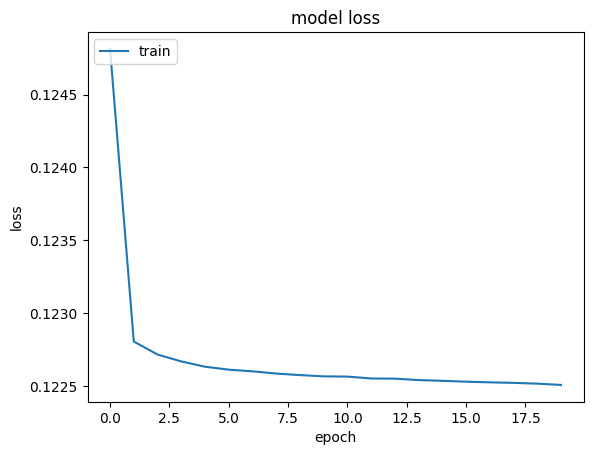

In [36]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

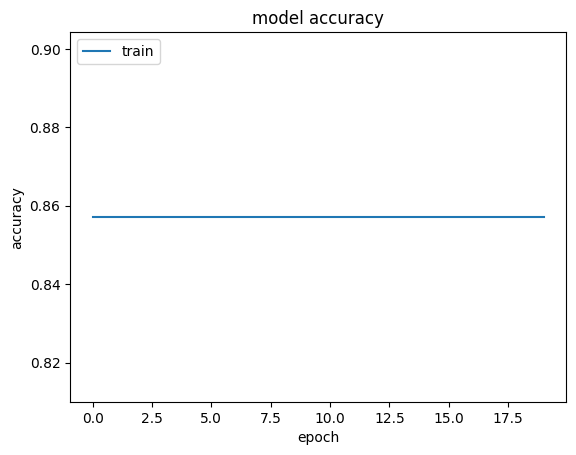

In [37]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()